In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from ipywidgets import interact
from ipywidgets import interactive
import ipywidgets as widgets
#from QSM_and_qBOLD_functions import f_qBOLD, f_QSM
from scipy.optimize import curve_fit
import scipy.integrate as integrate
import scipy.special as special

In [2]:
def f_hyper(x):
    '''
    Write hypergeometric function as taylor order 10 for beginning and as x-1 for larger numbers
    Exakt equation: hypergeom(-0.5,[0.75,1.25],-9/16*x.^2)-1
    (Intersection>x)*taylor + (x>=Intersection)*(x-1)
    taylor = - (81*x^8)/10890880 + (27*x^6)/80080 - (3*x^4)/280 + (3*x^2)/10
    Intersection at approx x = 3.72395
    
    '''
    Intersection = 3.72395
    a = (Intersection>x)*( -81./10890880*pow(x,8) +27./80080*pow(x,6) -3./280*pow(x,4) +0.3*pow(x,2) )
    b = (x>=Intersection)*(x-1)
    return a + b

In [3]:
def f_hyper_integral(x):
    output=[]
    for i in range(len(x)):
        output.append(1/3*integrate.quad(lambda u: (2+u)*np.sqrt(1-u)*(1-special.jv(0,1.5*x[i]*u))/u/u  ,0,1 )[0])
    return np.array(output)

f_hyper_integral([1,2,2.5])


array([0.28961556, 1.04836067, 1.52848196])

Hypergeometric Function is approx 0.3*x^2 for x <1.5 and x-1 for x>1.5

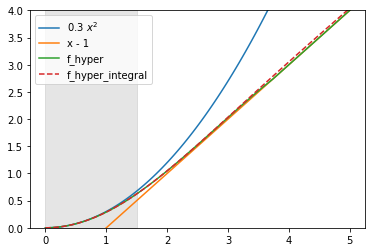

In [4]:
plt.figure()
x=np.linspace(0,5,num=100)
plt.plot(x,0.3*x**2,label='0.3 $x^2$')
plt.plot(x,x-1,label='x - 1')
plt.plot(x,f_hyper(x),label='f_hyper')
plt.plot(x,f_hyper_integral(x),'--',label='f_hyper_integral')
plt.fill_betweenx(y=[0,4],x1=0,x2=1.5,alpha=0.2,color='grey')
plt.ylim((0,4))
plt.legend()
plt.show()

In [5]:
def f_dw(Y,chi_nb):
    Hct = 0.357             
    psi_Hb = Hct*0.34/1.335 # Blood Hb volume fraction
    chi_oHb = -0.813        # Susceptibility of oxyhemoglobin in ppm
    chi_p = -0.0377         # Susceptibility of plasma in ppm
    chi_ba = psi_Hb*chi_oHb + (1-psi_Hb)*chi_p # Susceptibility of fully oxygenated blood in ppm
    delta_chi0 = 4*np.pi*0.273 #in ppm
    #CF = gamma *B0
    gamma = 267.513 #MHz/T
    B0 = 3 #T
    dw = 1./3 * gamma * B0* (Hct * delta_chi0 * (1-Y) + chi_ba - chi_nb )
    return dw


In [6]:
def f_qBOLD(t, S0, R2, Y, nu, chi_nb, TE = 40./1000 ):
    output=np.zeros_like(t)
    for i in range(len(t)):
        if(t[i]<TE/2): #FID
            output[i] = S0 * np.exp(-R2*t[i] -nu * f_hyper(f_dw(Y,chi_nb) *     t[i] ) )
        elif(t[i]>TE): #SE fall  
            output[i] = S0 * np.exp(-R2*t[i] -nu * f_hyper(f_dw(Y,chi_nb) * (t[i]-TE) ) )
        else:          #SE rise
            output[i] = S0 * np.exp(-R2*t[i] -nu * f_hyper(f_dw(Y,chi_nb) * (TE-t[i]) ) )
    return output


In [7]:
def f_qBOLD_multiparam(t,S0,R2,Y,nu):
    Hct = 0.357   
    gamma = 267.513 #MHz/T
    B0 = 3 #T
    delta_chi0 = 4*np.pi*0.273 #in ppm
    SaO2=0.98
    OEF = 1 - Y/SaO2
    R2s = R2 + nu * OEF * gamma*B0*Hct*delta_chi0/3
    print(R2s)
    return S0*np.exp(-R2s*t)

In [6]:
def f_QSM(Y, nu, chi_nb ):
    Hct = 0.357
    SaO2 = 0.98
    alpha = 0.77;              # Ratio of deoxygenated and total blood volume
    delta_chi_Hb = 12.522;     # Susceptibility difference between dHb and Hb in ppm
    psi_Hb = Hct*0.34/1.335    # Blood Hb volume fraction
    chi_oHb = -0.813           # Susceptibility of oxyhemoglobin in ppm
    chi_p = -0.0377            # Susceptibility of plasma in ppm
    chi_ba = psi_Hb*chi_oHb + (1-psi_Hb)*chi_p # Susceptibility of fully oxygenated blood in ppm

    blood = (chi_ba/alpha +psi_Hb*delta_chi_Hb * ((1-(1-alpha)*SaO2)/alpha - Y) )*nu
    non_blood = (1 - nu/alpha) * chi_nb
    return blood + non_blood

In [8]:
def f_exp(t,S0,R2s):
    return S0*np.exp(-R2s*t)

In [9]:
def f_OEF_Y(Y_v):
    Y_a = 0.98
    return 1 - Y_v/Y_a

In [10]:
def f_OEF_multiparam(R2,R2s,nu):
    gamma = 267.513 #MHz/T
    B0 = 3 #T
    Delta_chi = 0.27 #ppm
    Hct = 0.357
    a= 3/(4*np.pi*gamma*B0)
    b = (R2s-R2)/nu
    c = 1/(Delta_chi*Hct)
    return a*b*c

White Matter: R2 = 12 +- 6 Hz, Y = 60 +- 30 %, nu = 4 +- 2%, chi_nb = -0.04 +- 0.04 ppm
Grey Matter: R2 = 17 +- 4 Hz, Y = 60 +- 30 %, nu = 4 +- 2%, chi_nb = -0.05 +- 0.04 ppm

In [47]:
S0_slider = widgets.FloatSlider( min=   0, max=   2, value=  1, step=  .1, description='S0', continuous_update=False)
R2_slider = widgets.IntSlider(   min=   6, max=  21, value= 12,            description='R2 [Hz]', continuous_update=False)
Y_slider  = widgets.FloatSlider( min=   0, max= .98, value= .6, step= .01, description='Y', continuous_update=False)
nu_slider = widgets.FloatSlider( min= .02, max= .06, value= .04, step= .01, description='nu', continuous_update=False)
chi_nb_slider=widgets.FloatSlider(min=-.15, max=   0.1, value=-.04, step= .01, description='chi_nb [ppm]', continuous_update=False)
TE_slider = widgets.IntSlider(   min=  5,  max= 100, value= 40,            description='TE [ms]', continuous_update=False)
ui = widgets.HBox([S0_slider, R2_slider, Y_slider, nu_slider, chi_nb_slider, TE_slider])

In [48]:
def plot_Smoker(S0, R2, Y, nu, chi_nb):
    fig, axes = plt.subplots(nrows=2,ncols=1,figsize=(10,12))
    
    t = np.linspace(0, 160, num=100)/1000
    t_GRE = np.linspace(4.5,4.5+(12-1)*5.5,12)/1000
    t_GESSE = np.linspace(13.1,13.1+(12-1)*13.1,12)/1000
    
    qBOLD_values = f_qBOLD(t,S0, R2, Y, nu, chi_nb, 1000)
    qBOLD_multiparam = f_qBOLD_multiparam(t,S0, R2, Y, nu)
    GESSE_values = S0*np.exp(-R2*t)
    
    qBOLD_sampled = f_qBOLD(t_GRE,S0, R2, Y, nu, chi_nb, 1000)
    popt, pcov = curve_fit(f_exp, t_GRE, qBOLD_sampled)
    print(popt[1])
    GESSE_sampled = S0*np.exp(-R2*t_GESSE)
    
    axes[0].plot(t*1000,qBOLD_values,'r')
    axes[0].plot(t*1000,GESSE_values,'b')
    axes[0].plot(t*1000,qBOLD_multiparam,'g')
    axes[0].plot(t_GRE*1000,qBOLD_sampled,'or')
    axes[0].plot(t_GRE*1000,f_exp(t_GRE, popt[0],popt[1]))
    axes[0].plot(t_GESSE*1000,GESSE_sampled,'ob')
    
    axes[0].set_ylim(0, 1.1)
    axes[0].set_xlabel('t [ms]')
    t_trans = 1.5/f_dw(Y,chi_nb)*1000 #Transition of Hypergeometric function 
    axes[0].fill_betweenx(y=[0,1.1],x1=0,x2=t_trans,alpha=0.2,color='grey')
    
    axes[1].plot(t*1000,qBOLD_values/GESSE_values,'r')
    axes[1].plot(t_GRE*1000,qBOLD_sampled/(S0*np.exp(-R2*t_GRE)),'or')
    #axes[1].plot(t_GESSE*1000,GESSE_sampled,'ob')
    
    #axes[1].set_xlim(0, 70)
    #axes[1].set_ylim(0, 1.1)
    axes[1].set_xlabel('t [ms]')
    t_trans = 1.5/f_dw(Y,chi_nb)*1000 #Transition of Hypergeometric function 
    #axes[1].fill_betweenx(y=[0,1.1],x1=0,x2=t_trans,alpha=0.2,color='grey')
    
    plt.tight_layout()
    plt.show()

In [49]:
interactive_plot = interactive(plot_Smoker,S0=S0_slider, R2=R2_slider, Y=Y_slider, nu=nu_slider, chi_nb = chi_nb_slider, TE=TE_slider)
output = interactive_plot.children[-1]
output.layout.height = '900px'
interactive_plot

interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='S0', max=2.0), IntSlider(va…

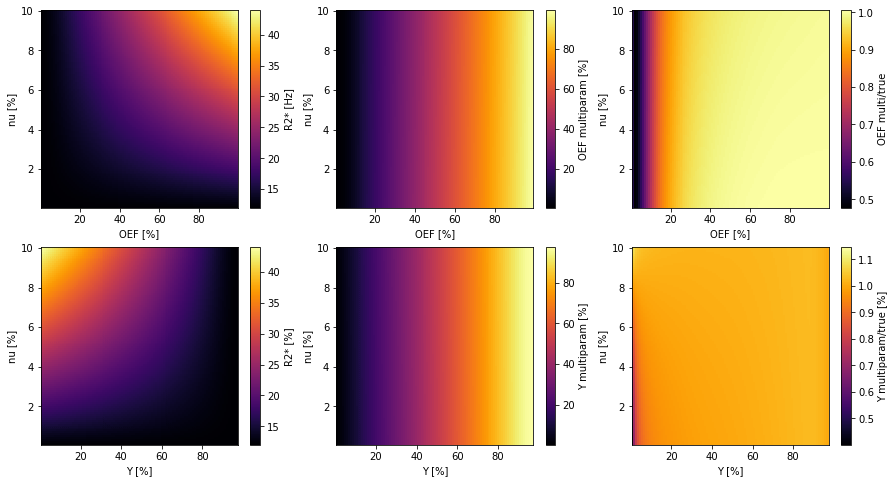

In [14]:
def plot_OEF_multiparam():
    t_GRE = np.linspace(4.5,4.5+(12-1)*5.5,12)/1000
    S0=1
    R2=12
    Y =np.linspace(1, 97, num=100)/100
    nu= np.linspace(0.1, 10, num=100)/100
    chi_nb=-0.1081913213483146
    R2s = np.zeros((len(Y),len(nu)))
    OEF_multi = np.zeros((len(Y),len(nu)))
    Y_multi = np.zeros((len(Y),len(nu)))
    OEF_true = np.zeros((len(Y),len(nu)))
    nu_grid = np.zeros((len(Y),len(nu)))
    Y_grid = np.zeros((len(Y),len(nu)))
    for i in range(len(Y)):
        for j in range(len(nu)):
            qBOLD= f_qBOLD(t_GRE,S0,R2,Y[i],nu[j],chi_nb,1000)    
            popt, pcov = curve_fit(f_exp, t_GRE, qBOLD)
            R2s[i,j] = popt[1]
            OEF_multi[i,j] = f_OEF_multiparam(R2,R2s[i,j],nu[j])
            Y_multi[i,j] = 0.98*(1-OEF_multi[i,j])
            OEF_true[i,j] = f_OEF_Y(Y[i])
            Y_grid[i,j] = Y[i]
            nu_grid[i,j] = nu[j]
            
    #OEF_true = f_OEF_Y(Y)
    #OEF_grid,nu_grid = np.meshgrid(OEF_true,nu)
        
    fig, axes = plt.subplots(nrows=2,ncols=3,figsize=(15,8))
    ax=axes.ravel()
    p0=ax[0].pcolor(OEF_true*100,nu_grid*100,R2s,shading='nearest',cmap='inferno')#,vmin=-30,vmax=120
    ax[0].set_xlabel('OEF [%]')
    ax[0].set_ylabel('nu [%]')
    cbar = fig.colorbar(p0, ax=ax[0])
    cbar.set_label('R2* [Hz]')
    
    p1=ax[1].pcolor(OEF_true*100,nu_grid*100,OEF_multi*100,shading='nearest',cmap='inferno')#,vmin=-30,vmax=120
    ax[1].set_xlabel('OEF [%]')
    ax[1].set_ylabel('nu [%]')
    cbar = fig.colorbar(p1, ax=ax[1])
    cbar.set_label('OEF multiparam [%]')
    
    p2=ax[2].pcolor(OEF_true*100,nu_grid*100,OEF_multi/OEF_true,shading='nearest',cmap='inferno')#,vmin=-30,vmax=120
    ax[2].set_xlabel('OEF [%]')
    ax[2].set_ylabel('nu [%]')
    cbar = fig.colorbar(p2, ax=ax[2])
    cbar.set_label('OEF multi/true')
    
    p3=ax[3].pcolor(Y_grid*100,nu_grid*100,R2s,shading='nearest',cmap='inferno')#,vmin=-30,vmax=120
    ax[3].set_xlabel('Y [%]')
    ax[3].set_ylabel('nu [%]')
    cbar = fig.colorbar(p3, ax=ax[3])
    cbar.set_label('R2* [%]')
    
    p4=ax[4].pcolor(Y_grid*100,nu_grid*100,Y_multi*100,shading='nearest',cmap='inferno')#,vmin=-30,vmax=120
    ax[4].set_xlabel('Y [%]')
    ax[4].set_ylabel('nu [%]')
    cbar = fig.colorbar(p4, ax=ax[4])
    cbar.set_label('Y multiparam [%]')
    
    p5=ax[5].pcolor(Y_grid*100,nu_grid*100,Y_multi/Y_grid,shading='nearest',cmap='inferno')#,vmin=-30,vmax=120
    ax[5].set_xlabel('Y [%]')
    ax[5].set_ylabel('nu [%]')
    cbar = fig.colorbar(p5, ax=ax[5])
    cbar.set_label('Y multiparam/true [%]')
    #ticks = list(cbar.get_ticks())

    # Append the ticks (and their labels) for minimum and the maximum value
    #cbar.set_ticks([minVal, maxVal] + ticks)
    #cbar.set_ticklabels(['min {: .1f}'.format(minVal), 'max {: .1f}'.format(maxVal)] + ticks)
    #plt.show()
plot_OEF_multiparam()

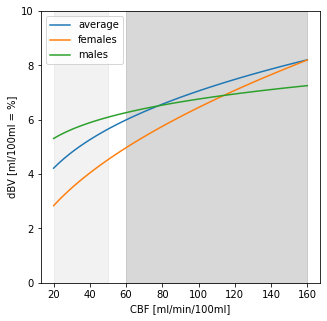

In [50]:
# https://onlinelibrary.wiley.com/doi/10.1002/mrm.24984
# Noninvasive MRI measurement of the absolute cerebral blood volume–cerebral blood flow relationship
# in the occipital cortex with and without visual stimulation in healthy humans
# Figure 4 in the paper shows curves of female and male CBF to CBV relation for each gender and for 9 ROIs.
# The curves vary a lot but the Smoker paper uses the average equation CBV = 2.1 *CBF^0.32 for everyone and everywhere
CBF = np.linspace(20,160,50)
fig, axes = plt.subplots(nrows=1,ncols=1,figsize=(5,5))
axes.plot(CBF, 0.77*2.1 * pow(CBF,0.32),label='average')
axes.plot(CBF, 0.77*0.8 * pow(CBF,0.51),label='females')
axes.plot(CBF, 0.77*4.4 * pow(CBF,0.15),label='males')
axes.set_xlabel('CBF [ml/min/100ml]')
axes.set_ylabel('dBV [ml/100ml = %]')
axes.legend()
axes.set_ylim((0,10))
axes.fill_betweenx(y=[0,10],x1=20,x2=50,alpha=0.1,color='grey')
axes.fill_betweenx(y=[0,10],x1=60,x2=160,alpha=0.3,color='grey')
plt.show()
# https://onlinelibrary.wiley.com/doi/full/10.1002/mrm.10257?sid=nlm%3Apubmed
# Cerebral venous and arterial blood volumes can be estimated separately in humans using magnetic resonance imaging
# DBV = 0.77 * CBV 
# not sure how trustworthy that 0.77 is. the images are very blurry and its a whole brain average.
# alpha = DBV/CBV=0.77 is used a lot in the QSM equation 


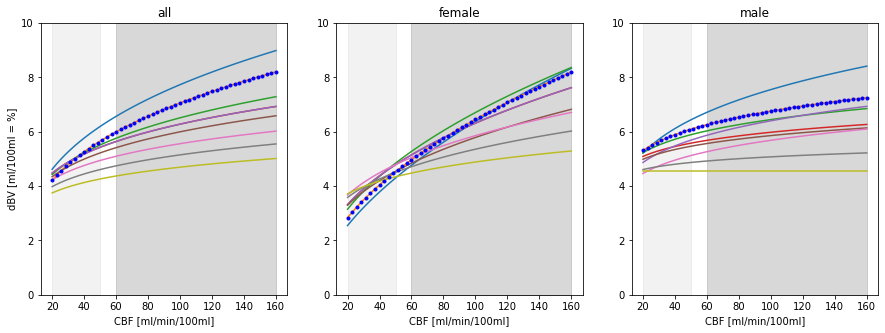

In [45]:
# values from 
# https://onlinelibrary.wiley.com/doi/10.1002/mrm.24984
# Noninvasive MRI measurement of the absolute cerebral blood volume–cerebral blood flow relationship
# 9 ROIs overlapping defined by different levels of activity in visual cortex
a_all = [2.3,2.1,2.8,3.1,3.1,3.1,3.3,3.2,3.2]
b_all = [0.32,0.32,0.24,0.21,0.21,0.20,0.17,0.16,0.14]
a_f   = [0.6,0.8,1.0,1.3,1.3,1.5,2.0,2.2,2.9]
b_f   = [0.57,0.51,0.47,0.40,0.40,0.35,0.29,0.25,0.17]
a_m   = [3.4,4.4,4.6,4.9,3.8,4.8,3.7,5.0,5.9]
b_m   = [0.23,0.15,0.13,0.10,0.17,0.10,0.15,0.06,0.00]
a = 2.1
b = 0.32
CBF = np.linspace(20,160,50)

def f_CBV_CBF(a,b,CBF):
    return a * pow(CBF,b)


fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(15,5))
ax=axes.ravel()
for i in range(len(a_all)):
    ax[0].plot(CBF,0.77*f_CBV_CBF(a_all[i],b_all[i],CBF))
    ax[1].plot(CBF,0.77*f_CBV_CBF(a_f[i],b_f[i],CBF))
    ax[2].plot(CBF,0.77*f_CBV_CBF(a_m[i],b_m[i],CBF))
ax[0].set_xlabel('CBF [ml/min/100ml]')
ax[0].set_ylabel('dBV [ml/100ml = %]')
ax[0].set_title('all')
ax[1].set_xlabel('CBF [ml/min/100ml]')
ax[1].set_title('female')
ax[2].set_xlabel('CBF [ml/min/100ml]')
ax[2].set_title('male')
ax[0].set_ylim((0,10))
ax[1].set_ylim((0,10))
ax[2].set_ylim((0,10))
ax[0].plot(CBF, 0.77*2.1 * pow(CBF,0.32),'.b')
ax[1].plot(CBF, 0.77*0.8 * pow(CBF,0.51),'.b')
ax[2].plot(CBF, 0.77*4.4 * pow(CBF,0.15),'.b')
ax[0].fill_betweenx(y=[0,10],x1=20,x2=50,alpha=0.1,color='grey')
ax[0].fill_betweenx(y=[0,10],x1=60,x2=160,alpha=0.3,color='grey')
ax[1].fill_betweenx(y=[0,10],x1=20,x2=50,alpha=0.1,color='grey')
ax[1].fill_betweenx(y=[0,10],x1=60,x2=160,alpha=0.3,color='grey')
ax[2].fill_betweenx(y=[0,10],x1=20,x2=50,alpha=0.1,color='grey')
ax[2].fill_betweenx(y=[0,10],x1=60,x2=160,alpha=0.3,color='grey')
plt.show()

In [38]:
0.77*2.1*pow(37,0.32)

5.13493052012324